In [0]:
import keras
from keras import backend as K
from keras.layers import Input, Lambda, Dense, Conv2D, Conv2DTranspose, MaxPool2D, Flatten, Reshape, Layer
from keras.models import Model
from keras import metrics
from keras.losses import mse, binary_crossentropy
from keras.datasets import mnist
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [0]:
batch_size = 128
epochs = 50
image_size = (28,28,1)
latent_dimension = 3 ## to view representation clusters in 3 dimensions

In [0]:
input_image = Input(shape=image_size, name='encoder_input')

In [0]:
## defining the inference network
## this is the network that will produce a latent space representation of the original image
## 5 layer convolutional network
encoder = Conv2D(16, (3,3), activation='relu', padding='same', name="encoder_conv1")(input_image)
encoder = MaxPool2D((2,2), padding="same", name="encoder_pool1")(encoder)
encoder = Conv2D(8, (3,3), activation='relu', padding='same', name="encoder_conv2")(encoder)
encoder = MaxPool2D((2,2), padding="same", name="encoder_pool2")(encoder)
encoder = Conv2D(4, (3,3), activation='relu', padding='same', name="encoder_conv3")(encoder)
encoder_shape = K.int_shape(encoder)
encoder = Flatten()(encoder) ## turns output to size of (None, 196)
encoder = Dense(32, activation='relu')(encoder)

z_mean = Dense(latent_dimension, name="z_mean")(encoder)
z_var = Dense(latent_dimension, name="z_var")(encoder)

In [0]:
## defining the sampling method for the generator network
def normal_sample(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dimension),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon
z = Lambda(normal_sample, name="z_sample", output_shape=(latent_dimension,))([z_mean, z_var])
encoder = Model(input_image, [z_mean, z_var, z], name='encoder')

In [6]:
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
encoder_conv1 (Conv2D)          (None, 28, 28, 16)   160         encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_pool1 (MaxPooling2D)    (None, 14, 14, 16)   0           encoder_conv1[0][0]              
__________________________________________________________________________________________________
encoder_conv2 (Conv2D)          (None, 14, 14, 8)    1160        encoder_pool1[0][0]              
__________________________________________________________________________________________________
encoder_po

In [0]:
## building decoder model

filters = 16
kernel_size = 3

latent_inputs = Input(shape=(latent_dimension,), name='z_sampling')
decoder = Dense(encoder_shape[1] * encoder_shape[2] * encoder_shape[3], activation='relu')(latent_inputs)
decoder = Reshape(encoder_shape[1:])(decoder)
for i in range(2):
    decoder = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(decoder)
    filters //= 2
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(decoder)
decoder = Model(latent_inputs, outputs, name='decoder')

In [0]:
outputs = decoder(encoder(input_image)[2])

In [9]:
from keras.datasets import mnist

vae = Model(input_image, outputs)
reconstruction_loss = binary_crossentropy(K.flatten(input_image),
                                                  K.flatten(outputs))
kl_loss = 1 + z_var - K.square(z_mean) - K.exp(z_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

# Train the VAE on MNIST digits
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

history = vae.fit(x_train,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None)
       )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Output "decoder" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder" during training.
  # This is added back by InteractiveShellApp.init_path()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 3), (None, 3), (N 8114      
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         2609      
Total params: 10,723
Trainable params: 10,723
Non-trainable params: 0
_________________________________________________________________
11493376/11490434 [==============================] - 3s 0us/step
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 7040/60000 [==>...........................] - ETA: 1:21 - loss: 0.5527

60000/60000 [==============================] - 91s 2ms/step - loss: 0.3202 - val_loss: 0.2670
Epoch 2/10
51712/60000 [========================>.....] - ETA: 11s - loss: 0.2655

60000/60000 [==============================] - 89s 1ms/step - loss: 0.2655 - val_loss: 0.2639
Epoch 3/10
60000/60000 [==============================] - 91s 2ms/step - loss: 0.2639 - val_loss: 0.2634
Epoch 4/10
 6016/60000 [==>...........................] - ETA: 1:18 - loss: 0.2636

60000/60000 [==============================] - 92s 2ms/step - loss: 0.2635 - val_loss: 0.2631
Epoch 5/10
51200/60000 [========================>.....] - ETA: 13s - loss: 0.2633

60000/60000 [==============================] - 93s 2ms/step - loss: 0.2634 - val_loss: 0.2630
Epoch 6/10
60000/60000 [==============================] - 93s 2ms/step - loss: 0.2633 - val_loss: 0.2628
Epoch 7/10
 5632/60000 [=>............................] - ETA: 1:20 - loss: 0.2631

60000/60000 [==============================] - 92s 2ms/step - loss: 0.2632 - val_loss: 0.2628
Epoch 8/10
50816/60000 [========================>.....] - ETA: 13s - loss: 0.2630

60000/60000 [==============================] - 93s 2ms/step - loss: 0.2632 - val_loss: 0.2629
Epoch 9/10
60000/60000 [==============================] - 92s 2ms/step - loss: 0.2631 - val_loss: 0.2630
Epoch 10/10
 5632/60000 [=>............................] - ETA: 1:19 - loss: 0.2632

60000/60000 [==============================] - 92s 2ms/step - loss: 0.2631 - val_loss: 0.2628


In [0]:
import matplotlib.pyplot as plt

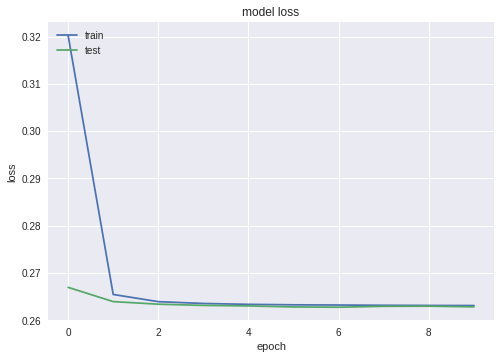

In [14]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [73]:
## for 3d latent space plotting
from mpl_toolkits.mplot3d import Axes3D
latent_points = encoder.predict(x_test)

AttributeError: ignored

In [0]:
len(latent_points[0])

In [0]:
numpy_latent_test = np.array(latent_points[2])
numpy_latent_test = numpy_latent_test.reshape((10000,3))

In [0]:
numpy_latent_test = list(map(list, numpy_latent_test))
xs = list(map(lambda point_array: point_array[0], numpy_latent_test))
ys = list(map(lambda point_array: point_array[1], numpy_latent_test))
zs = list(map(lambda point_array: point_array[2], numpy_latent_test))

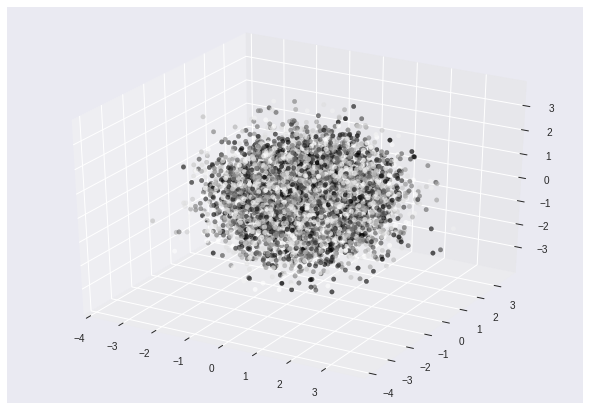

In [85]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(xs, ys, zs=zs, c=y_test)
plt.show()

In [72]:
x_test.shape

(10000, 28, 28, 1)